In [12]:
from __init__ import *
import Setting as _C
reload(_C)
import utils as _U
reload(_U)
import Features as _F
reload(_F)
import Dataloader as _D
reload(_D)

<module 'Dataloader' from 'c:\\Users\\shuai.song\\data\\Causis\\CTA_Trend\\Dataloader.py'>

In [13]:
trading_logs = {}
all_buy = pd.DataFrame()
all_sell = pd.DataFrame()
all_total = pd.DataFrame()

for com in _D.commodities.keys():
    com_log = np.load(f'output/trading_logs/{_C.VERSION}/{com}_logs.npy', allow_pickle=True)
    com_log = com_log.tolist() # [BUY_log, SELL_log, TOTAL_log]
    trading_logs[com] = com_log

In [224]:
# def Judge_Pos(com):
#     ddf = pd.read_csv(f'output/features/{com}_features.csv')
#     ddf = ddf.set_index('CLOCK.1')

#     ddf['signal'] = np.zeros(ddf.shape[0])
#     clock_list = ddf['CLOCK'].to_list()

#     for i in range(trading_logs[com][0].shape[0]):
#         entry = trading_logs[com][0].iloc[i]
#         start = entry['open_bar']
#         end = entry['close_bar']
#         ddf['signal'].loc[start: end] = 1

#     for i in range(trading_logs[com][1].shape[0]):
#         entry = trading_logs[com][1].iloc[i]
#         start = entry['open_bar']
#         end = entry['close_bar']
#         ddf['signal'].loc[start: end] = -1

#     return ddf

In [14]:
F_data=  {}
## Positions
for com in tqdm(_D.commodities.keys(), desc='loading data'):
    ddf = pd.read_csv(f'output/features/{_C.VERSION}/{com}_features.csv')
    ddf = ddf.set_index('CLOCK', drop=False)
    F_data[com] = ddf

loading data: 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


In [ ]:
# F_data=  {}
# tasks = []
# ## Positions
# for com in _C.commodities.keys():
#     tasks.append(delayed(Judge_Pos)(com))

# multi_work = Parallel(n_jobs=8, backend='threading', verbose=80)
# res = multi_work(tasks)

# for com in _C.commodities.keys():
#     F_data[com] = res[list(_C.commodities.keys()).index(com)]

In [15]:
def plot_all(scom, t_start, t_end):
    
    stmp = F_data[scom][t_start:t_end].copy(deep=True)
    stmp = _U.price_adj(stmp, _C.PADJ)

    stmp['signal'] = stmp['position']/np.abs(stmp['position'])
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 5), dpi=150, sharex=True)
    axes[0].tick_params(labelsize=7)
    axes[1].tick_params(labelsize=7)

    ## Subplot 0
    # K bars
    axes[0].set_title(f'{scom} {t_start}--{t_end}')
    sdf = pd.DataFrame()
    sdf['CLOCK'] = stmp['CLOCK'].apply(lambda x: pd.to_datetime(x))
    sdf = sdf.set_index('CLOCK')
    sdf['Open'] = stmp['OPEN_adj']
    sdf['Close'] = stmp['CLOSE_adj']
    sdf['High'] = stmp['HIGH_adj']
    sdf['Low'] = stmp['LOW_adj']
    sdf['Volume'] = stmp['VOLUME']

    mc = mpf.make_marketcolors(up='red', down='green', edge='black')
    s = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc, y_on_right=False)
    mpf.plot(sdf, ax = axes[0], type='candle', style = s, ylabel='')
    
    # Super Trends
    stmp['UB_S'].loc[stmp['STD_S']== 1] = np.nan
    stmp['LB_S'].loc[stmp['STD_S']==-1] = np.nan

    stmp['UB_L'].loc[stmp['STD_L']== 1] = np.nan
    stmp['LB_L'].loc[stmp['STD_L']==-1] = np.nan

    stmp['UB_P'].loc[stmp['STD_P']== 1] = np.nan
    stmp['LB_P'].loc[stmp['STD_P']==-1] = np.nan

    stmp['UB_S'].plot(ax=axes[0], color='g', linestyle='--', alpha=0.8, linewidth=0.6)
    stmp['LB_S'].plot(ax=axes[0], color='r', linestyle='--', alpha=0.8, linewidth=0.6)

    stmp['UB_L'].plot(ax=axes[0], color='skyblue', linestyle='-.', alpha=0.8, linewidth=1.)
    stmp['LB_L'].plot(ax=axes[0], color='orange', linestyle='-.', alpha=0.8, linewidth=1.)

    # stmp['UB_P'].plot(ax=axes[0], color='blue', linestyle='-', alpha=0.8, linewidth=1.2)
    # stmp['LB_P'].plot(ax=axes[0], color='purple', linestyle='-', alpha=0.8, linewidth=1.2)

    axes[0].legend()

    ## Subplot 1
    stmp['CLOSE'].plot(ax=axes[1], color='b', alpha=0.8, linewidth=0.8)
    ax_twin = axes[1].twinx()
    ax_twin.tick_params(labelsize=7)
    ax_twin.set_ylim(-1,1)
    axes[1].legend(loc='upper right')

    BUY_POS = stmp.copy(deep=True)
    BUY_POS['signal'].loc[BUY_POS['signal']!=1]=0
    plt.bar(BUY_POS.index.to_list(), BUY_POS['signal'], color='pink', alpha=0.5, label='BUY Pos')

    SELL_POS = stmp.copy(deep=True)
    SELL_POS['signal'].loc[SELL_POS['signal']!=-1]=0
    plt.bar(SELL_POS.index.to_list(), SELL_POS['signal'], color='green', alpha=0.5, label='SELL Pos')
    ax_twin.legend(loc='upper left')

    x_ticks = []
    for i in range(stmp.shape[0]):
        if i % 10 == 0:
            x_ticks.append(stmp['CLOCK'].iloc[i])
        else:
            x_ticks.append('')
    ax_twin.set_xticklabels(labels=x_ticks,visible=True)

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

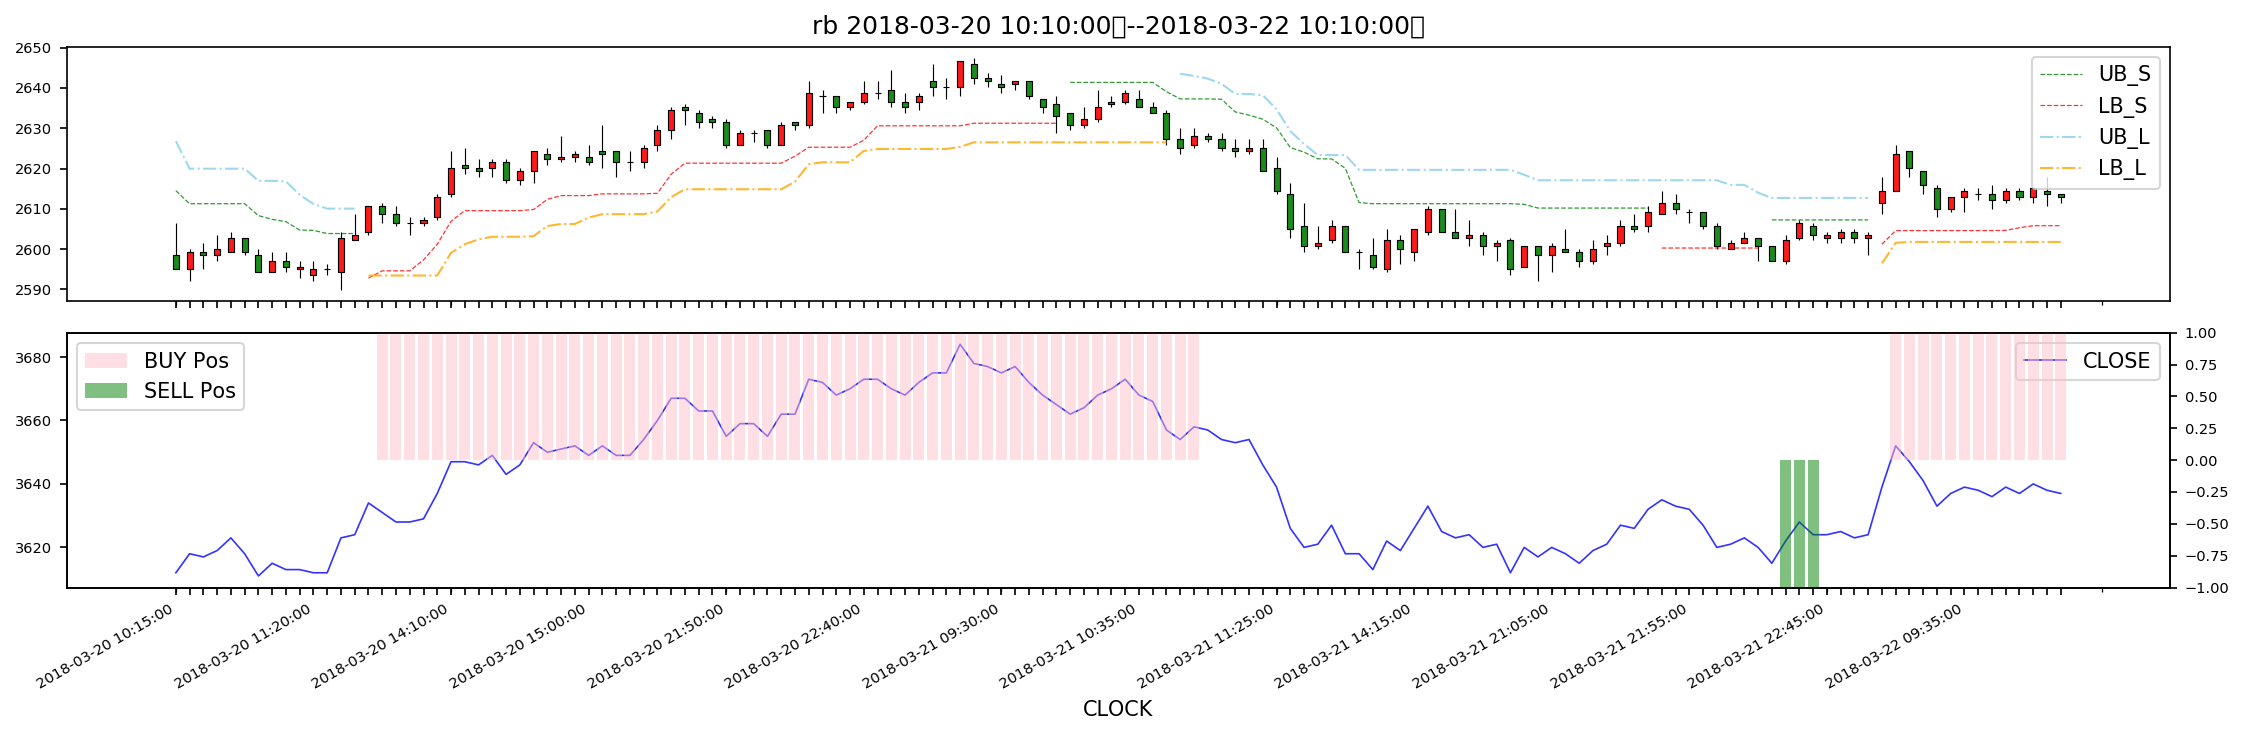

In [18]:
plot_all('rb', '2018-03-20 10:10:00	', '2018-03-22 10:10:00	')

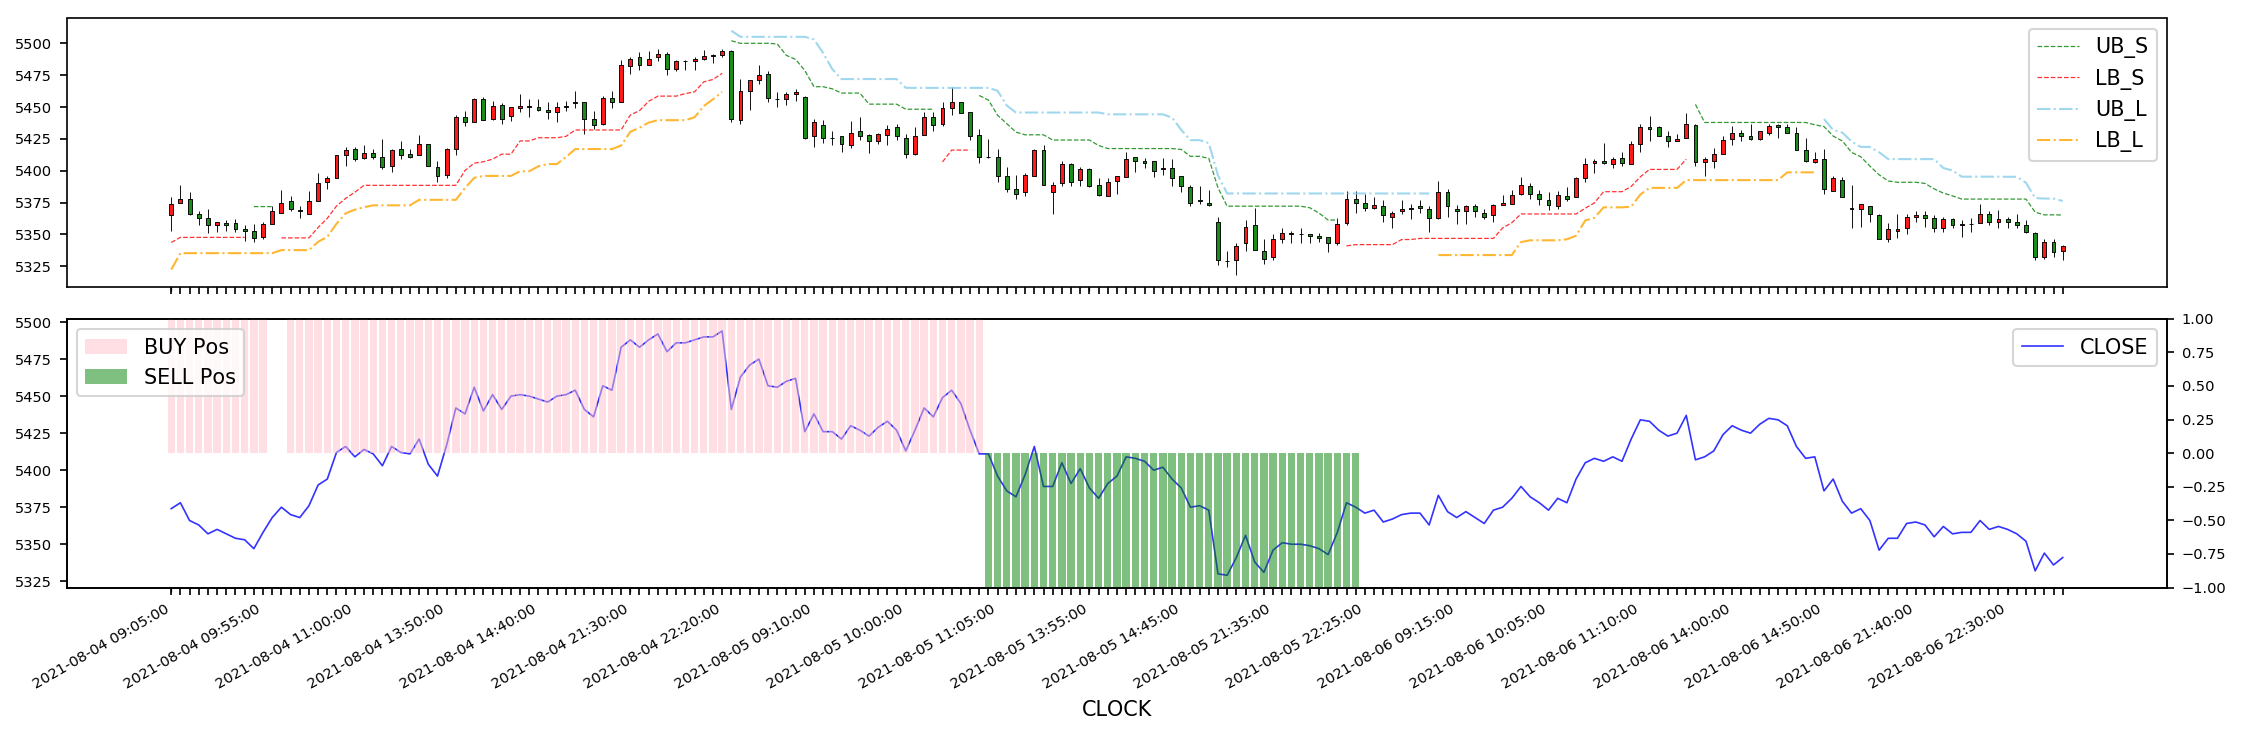

In [86]:
plot_all('rb', '2021-08-04 09:01:00	', '2021-08-07 10:10:00	')